# Exercise 1
1. read wav & lab file
2. normalize signal in [0, 1]
3. calculate STE
4. train model to classify speech and silence
5. test with test data

### Import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.io.wavfile import read
import warnings
warnings.simplefilter("ignore", category=wavfile.WavFileWarning)

### Create directory of .wav & .lab file and read file

In [2]:
def create_dir(folders, train_file, test_file, ext):
    train = []; test = []
    for folder in folders:
        if folder == "TinHieuHuanLuyen":
            for file in train_dir:
                path = "./" + folder + "/" + file + "." + ext
                train.append(path)
        else:
            for file in test_dir:
                path = "./" + folder + "/" + file + "." + ext
                test.append(path)
    return train, test

In [3]:
def Read_lab(path):
    f = open(path, "r")
    lines = f.readlines()
    speech_reg = []; start = 0.00; end = 0.00
    for line in lines:
        temp = line.split()
        if temp[-1] == 'sil' and temp[0] == '0.00':
            speech_reg.append(temp[1])
        if temp[-1] == 'sil' and temp[0] != '0.00':
            speech_reg.append(temp[0])
            end = temp[1]
    return speech_reg, start, end

#### Calculate STE of frames

In [4]:
def compute_ste(signal, fs, t1, t2, win_size, hop_size):
    start = int(t1 * fs); end = int(t2 * fs)
    frames = np.array([signal[i:i+win_size] for i in range(start, end-win_size, hop_size)])
    ste = np.sum(np.square(frames), axis=1)
    return ste

### Get train data from 'TinHieuHuanLuyen'

In [5]:
# Prepare .wav & .lab dir
folder_dir = ["TinHieuHuanLuyen", "TinHieuKiemThu"]
train_dir = ["Phone_F2", "Phone_M2", "Studio_F2", "Studio_M2"]
test_dir = ["Phone_F1", "Phone_M1", "Studio_F1", "Studio_M1"]
train_dirs, test_dirs = create_dir(folder_dir, train_dir, test_dir, "wav")
train_lab, test_lab = create_dir(folder_dir, train_dir, test_dir, "lab")


# Get data to train
def Get_data(file, lab, name):
    x = []      # Contain ste
    y = []      # Contain label
    for i in range(len(file)):
        # Load data from .wav & .lab file
        fs, data = read(file[i])
        data = data.astype(np.float64)

        # Window & hop size
        window_size = int(0.03 * fs)
        hop_size = int(0.02 * fs)

        # Prepare X (STE), y (label) to train
        speech_region, start_sig, end_sig = Read_lab(lab[i])
        timeline = [start_sig, speech_region[0], speech_region[1], end_sig]
        print(f"{name[i]} : {timeline}")

        # Compute ste & label
        Ste = []; label = []
        for it in range(0, len(timeline)-1):
            a = float(timeline[it]); b = float(timeline[it+1])
            ste = compute_ste(data, fs, a, b, window_size, hop_size)
            Ste += ste.tolist()
            if it == 0 or it == 2:
                label += [0 for _ in range(ste.shape[0])]
            else:
                label += [1 for _ in range(ste.shape[0])]
        Ste = np.array(Ste)
        Ste = (Ste - np.min(Ste)) / (np.max(Ste) - np.min(Ste))
        Ste = Ste.tolist()
        x += Ste
        y += label

    print("-> len(x_train), len(y_train):", len(x), len(y))
    return  x, y

# Train data
x_train, y_train = Get_data(train_dirs, train_lab, train_dir)

Phone_F2 : [0.0, '1.02', '4.04', '4.80']
Phone_M2 : [0.0, '0.53', '2.52', '2.80']
Studio_F2 : [0.0, '0.77', '2.37', '3.14']
Studio_M2 : [0.0, '0.45', '1.93', '2.38']
-> len(x_train), len(y_train): 641 641


## Softmax Regression

In [6]:
# Convert label to one hot encoding
def one_hot(y, n_classes=2):
    y_hot = np.zeros((len(y), n_classes))
    y_hot[np.arange(len(y)), y] = 1
    return y_hot

In [7]:
class SoftmaxRegression:
    def __init__(self, lr=0.05, epoch_max=20001, theta=None, batch_size=180):
        self.lr = lr
        self.epoch_max = epoch_max
        self.batch_size = batch_size
        self.theta = theta
        self.losses = []

    def softmax(self, z):
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def loss(self, h, y):
        return -np.mean(np.sum(y * np.log(h), axis=1))

    def fit(self, X, y):
        X = np.c_[X, np.ones([len(X), 1])]
        self.batch_size = X.shape[0]

        if self.theta is None:
            self.theta = np.random.randn(X.shape[1], 2)

        for epoch in range(self.epoch_max):
            mix_idx = np.random.permutation(X.shape[0])
            x_batch = X[mix_idx, :]
            y_batch = y[mix_idx, :]

            z = x_batch @ self.theta
            y_hat = self.softmax(z)
            gradient = x_batch.T @ (y_hat - y_batch) / self.batch_size
            self.theta = self.theta - self.lr * gradient

            if epoch % 100 == 0:
                loss = self.loss(y_hat, y_batch)
                self.losses.append(loss)
                # print(epoch, ":", loss)

    def predict(self, X, y, theta):
        X = np.c_[X, np.ones([len(X), 1])]
        y_hat = self.softmax(X @ theta)
        y_predict = np.argmax(y_hat, axis=1)
        accuracy = np.mean(y_predict == y)
        return y_predict, accuracy

### Training based on data from 'TinHieuHuanLuyen'

In [8]:
# Train
X_train = np.array(x_train).reshape(-1, 1).astype(np.float64)
Y_train = one_hot(y_train, n_classes=2).astype(np.int64)

model = SoftmaxRegression(lr=0.05, epoch_max=20001)
model.fit(X_train, Y_train)

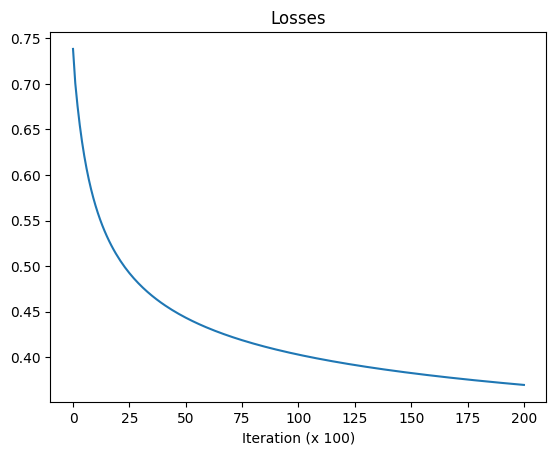

In [9]:
# Plot losses of model
plt.plot(model.losses)
plt.xlabel("Iteration (x 100)")
plt.title("Losses")
plt.show()

In [10]:
theta = model.theta.copy()
print("Theta:", "\n" ,theta)

Theta: 
 [[-10.36753683   9.18152054]
 [  0.85282117   0.31694728]]


In [17]:
threshold = np.arange(0, 100000, 1) / 100000        # validation set
thres, _ = model.predict(threshold, threshold, theta)
train_threshold = np.sum(thres == 0) / len(threshold)
print("=> Threshold:", train_threshold)

=> Threshold: 0.02742


### Filter Function: Use to filter and remove some virtual silence segment which less than 0.3 second in signal

In [12]:
def FilterVirtualSilence(label, fs, hop_size):
    min_silence_duration = 0.3      # seconds
    consecutive_zero = 0

    for i in range(len(label)):
        if label[i] == 0:
            consecutive_zero += 1
        else:
            if consecutive_zero * hop_size / fs <= min_silence_duration:
                label[i-consecutive_zero:i] = [1]*consecutive_zero
            consecutive_zero = 0

    if consecutive_zero < 10:
        label[-consecutive_zero:] = [1]*consecutive_zero

    return label

### Testing based on data from 'TinHieuKiemThu'

'Phone_F1'
=> Accuracy before filter: 71.51898734177216 %
=> Accuracy after filter: 99.36708860759494 %
- Speech region (True): 0.53 - 2.75
- Speech region (Predict): 0.535 - 2.695
--------------------------------------------------
'Phone_M1'
=> Accuracy before filter: 80.3921568627451 %
=> Accuracy after filter: 100.0 %
- Speech region (True): 0.46 - 3.52
- Speech region (Predict): 0.455 - 3.475
--------------------------------------------------
'Studio_F1'
=> Accuracy before filter: 92.08633093525181 %
=> Accuracy after filter: 100.0 %
- Speech region (True): 0.68 - 2.15
- Speech region (Predict): 0.675 - 2.095
--------------------------------------------------
'Studio_M1'
=> Accuracy before filter: 90.15151515151516 %
=> Accuracy after filter: 97.72727272727273 %
- Speech region (True): 0.87 - 2.06
- Speech region (Predict): 0.895 - 1.975
--------------------------------------------------


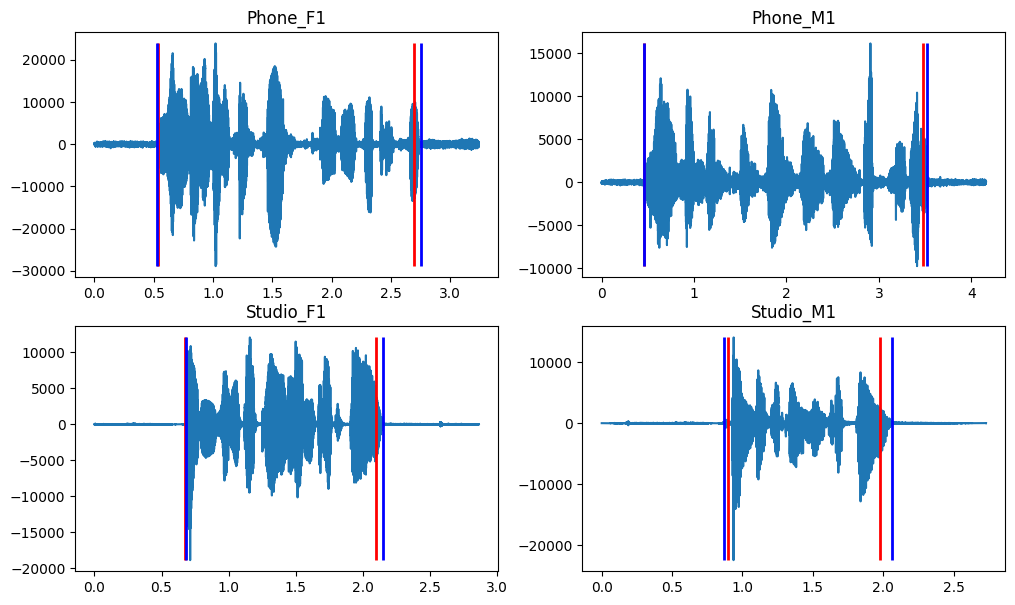

In [13]:
Ste = []; label = []
predict_label = []

# Get data from test
def Get_TestData(file, lab):
    signals = []; timelines = []
    win_sizes = []; hop_sizes = []; rate = []
    x_test, y_test = [], []

    for i in range(4):
        # Load data from .wav & .lab file
        fs, data = read(file[i])
        data = data.astype(np.float64)
        signals.append(data)

        # Window & hop size
        window_size = int(0.03 * fs)
        hop_size = int(0.02 * fs)
        win_sizes.append(window_size)
        hop_sizes.append(hop_size)
        rate.append(fs)

        # Prepare x_test (STE), true_label (label)
        speech_region, start_sig, end_sig = Read_lab(lab[i])
        timeline = [start_sig, speech_region[0], speech_region[1], end_sig]
        timelines.append(timeline)

        Ste = []; label = []
        for it in range(0, len(timeline)-1):
            a = float(timeline[it]); b = float(timeline[it+1])
            ste = compute_ste(data, fs, a, b, window_size, hop_size)
            Ste += ste.tolist()
            if it == 0 or it == 2:
                label += [0 for _ in range(ste.shape[0])]
            else:
                label += [1 for _ in range(ste.shape[0])]
        Ste = np.array(Ste)
        Ste = (Ste - np.min(Ste)) / (np.max(Ste) - np.min(Ste))
        Ste = Ste.tolist()
        x = np.array(Ste).reshape(-1, 1).astype(np.float64)
        true_label = np.array(label)

        x_test.append(x); y_test.append(true_label)
    return signals, timelines, x_test, y_test, win_sizes, hop_sizes, rate


signals, timelines, x_test, y_test, win_sizes, hop_sizes, rate = Get_TestData(test_dirs, test_lab)
j = 0
fig, ax = plt.subplots(nrows=2, ncols=2,
                        figsize=(12,7))

for i in range(4):
    data, fs = signals[i], rate[i]
    timeline = timelines[i]
    win_size = win_sizes[i]
    hop_size = hop_sizes[i]
    time = np.arange(len(data)) / fs

    # Predict label
    predicts, accuracy = model.predict(x_test[i], y_test[i], model.theta)
    filter_predict = FilterVirtualSilence(predicts, fs, hop_size)
    predict_label.append(filter_predict)
    accuracy_filter = np.mean(filter_predict == y_test[i])

    # Accuracy of detecting speech & silence
    print(f"'{test_dir[i]}'")
    print(f"=> Accuracy before filter: {accuracy * 100} %")
    print(f"=> Accuracy after filter: {accuracy_filter * 100} %")

    # Calculated start & end of speech
    speech_idx = [np.where(filter_predict == 1)[0][0], np.where(filter_predict == 1)[0][-1]]
    speech_idx_true = [np.where(y_test[i] == 1)[0][0], np.where(y_test[i] == 1)[0][-1]]
    # start = speech_idx[0] * hop_size/ fs
    # end = speech_idx[-1] * hop_size / fs
    start = (speech_idx[0] * hop_size + (win_size / 2)) /fs
    end = (speech_idx[-1] * hop_size + (win_size / 2)) /fs
    print(f"- Speech region (True): {timeline[1]} - {timeline[-2]}")
    print(f"- Speech region (Predict): {start} - {end}")
    print("-"*50)

    if j > 1:
        j = 0
    if i <= 1:
        ax[0, j].plot(time, data)
        ax[0, j].vlines(start, ymin=min(data), ymax=max(data), linewidth=2, colors='r', linestyle='solid')
        ax[0, j].vlines(end, ymin=min(data), ymax=max(data), linewidth=2,colors='r', linestyle='solid')
        ax[0, j].vlines(float(timeline[1]), ymin=min(data), ymax=max(data), linewidth=2, colors='b', linestyle='solid')
        ax[0, j].vlines(float(timeline[-2]), ymin=min(data), ymax=max(data), linewidth=2,colors='b', linestyle='solid')
        ax[0, j].title.set_text(test_dir[i])
    else:
        ax[1, j].plot(time, data)
        ax[1, j].vlines(start, ymin=min(data), ymax=max(data), linewidth=2, colors='r', linestyle='solid')
        ax[1, j].vlines(end, ymin=min(data), ymax=max(data), linewidth=2,colors='r', linestyle='solid')
        ax[1, j].vlines(float(timeline[1]), ymin=min(data), ymax=max(data), linewidth=2, colors='b', linestyle='solid')
        ax[1, j].vlines(float(timeline[-2]), ymin=min(data), ymax=max(data), linewidth=2,colors='b', linestyle='solid')
        ax[1, j].title.set_text(test_dir[i])
    j += 1

## Summary
- Phone files before filter "virtual silence regions" have lower accuracies compare to Studio files --> Because those Phone files have much more "virtual silence regions" than Studio files
- Accuracies are quite good after removing "virtual silence region"